# Spectroscopic data products

Here we summarize the files available for the DJA reductions of the public NIRSpec MSA datasets.

The full interactive table can be found [here](https://s3.amazonaws.com/msaexp-nirspec/extractions/nirspec_graded.html) and with an associated CSV catalog [nirspec_graded_v0.ecsv](https://s3.amazonaws.com/msaexp-nirspec/extractions/nirspec_graded_v0.ecsv).

In [1]:
%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

import astropy.io.fits as pyfits
import astropy.units as u

import sep

import grizli
from grizli import utils
print(f'grizli version: {grizli.__version__}')

import msaexp
import msaexp.spectrum
print(f'msaexp version: {msaexp.__version__}')

BASE_URL = 'https://s3.amazonaws.com/msaexp-nirspec/extractions/'
PATH_TO_FILE = BASE_URL + '{root}/{file}'

grizli version: 1.10.dev3+g341a999
msaexp version: 0.6.12.dev5+ge335c82.d20230530


# Full summary catalog

`grade` based on visual inspection of *individual* spectra.  That is, a particular object can have multiple entries in the table and only `grade=3` for the `grating+filter` combination that showed robust features.

- **3** = Robust
- **2** = Perhaps line or continuum features, but ambiguous redshift
- **1** = No features
- **0** = DQ problem



In [2]:
nrs = utils.read_catalog(BASE_URL + 'nirspec_graded_v0.ecsv', format='ascii.ecsv')

In [3]:
print('# Grade')
un = utils.Unique(nrs['grade'])

# Grade
   N  value     
====  ==========
 381           0
 624           2
1810           3
2309           1


In [4]:
# By grating
grat = utils.Unique(nrs['grating'])

   N  value     
====  ==========
 176  G235H     
 179  G140H     
 331  G395H     
 574  G395M     
 598  G140M     
 607  G235M     
2659  PRISM     


In [5]:
# By project
root = utils.Unique(nrs['root'])

   N  value     
====  ==========
  69  macsj0647-single-v1
 101  smacs0723-ero-v1
 111  abell2744-ddt-v1
 117  snH0pe-v1 
 132  macsj0647-v1
 143  rxj2129-ddt-v1
 154  gds-deep-hr-v1
 182  goodsn-wide-v1
 266  ceers-ddt-v1
 294  gds-deep-lr-v1
 405  whl0137-v1
 532  abell2744-glass-v1
 654  gds-deep-mr-v1
 906  ceers-mr-v1
1058  ceers-lr-v1


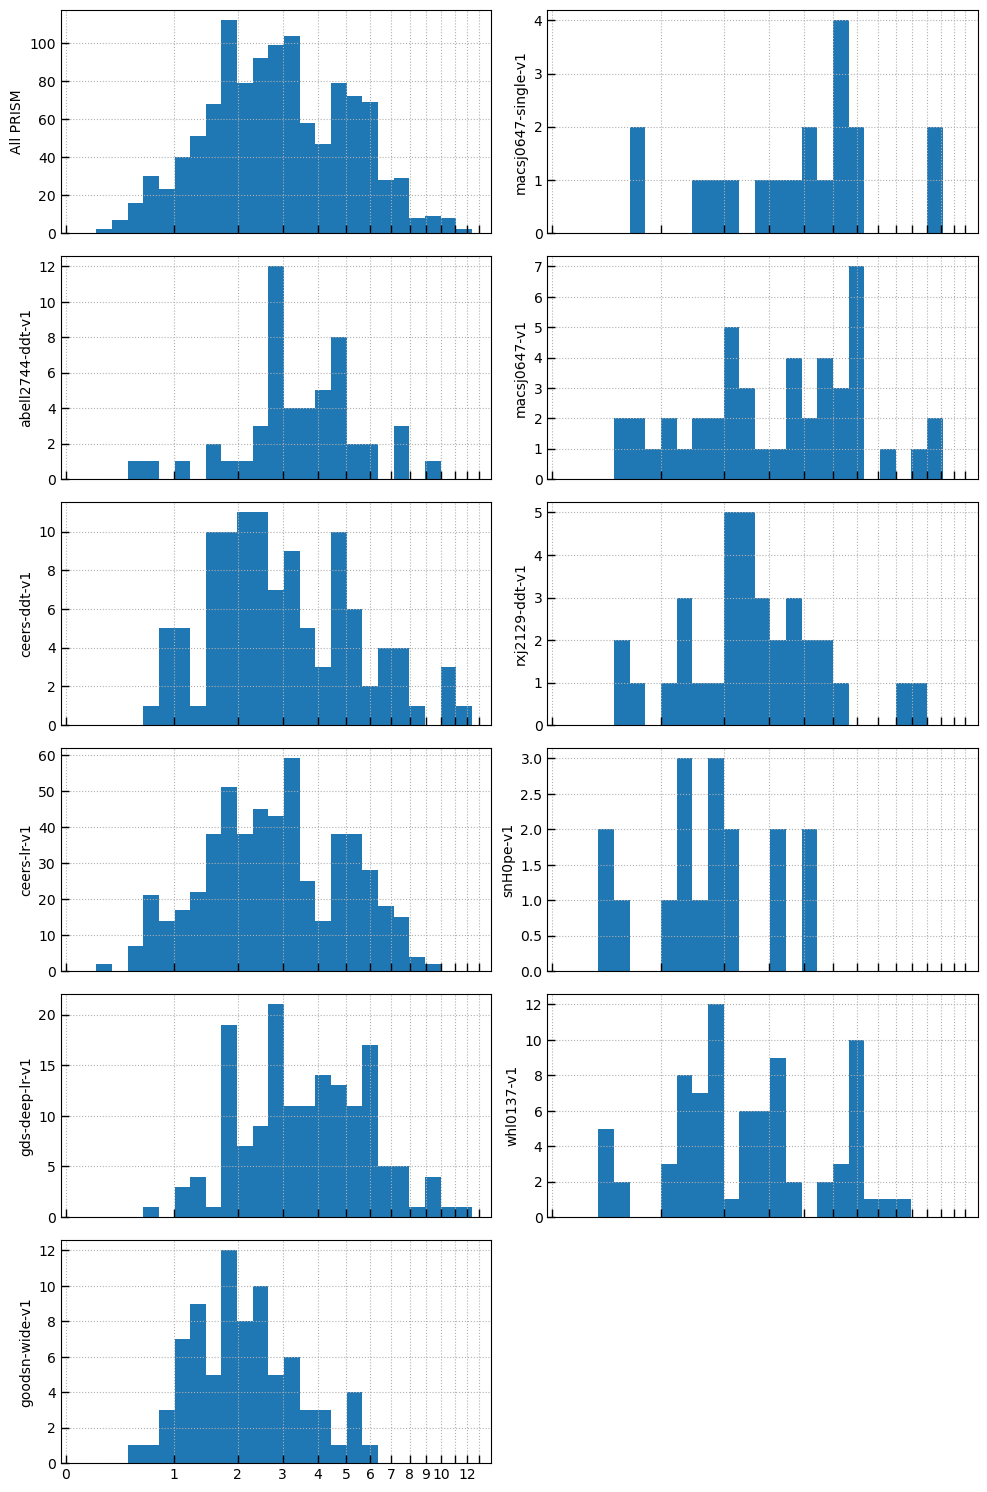

In [6]:
# Robust redshifts
robust_prism = (nrs['grating'] == 'PRISM') & (nrs['grade'] == 3)

roots = utils.Unique(nrs['root'][robust_prism], verbose=False)

nx = 2
ny = int(np.ceil((len(roots) + 1) / 2))

sx = 2.5

fig, axes = plt.subplots(ny,nx,sharex=True, sharey=False, figsize=(nx*sx*2, ny*sx))

lnz = np.log(1+nrs['z'])

bins = utils.log_zgrid([0.1, 13], 0.1)

xtv = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
xtl = [0,1,2,3,4,5,6,7,8,9,10,'',12,'']

_ = axes[0][0].hist(lnz[robust_prism], bins=np.log(1+bins))
axes[0][0].set_ylabel('All PRISM')
axes[0][0].grid()

count = 0

for root in roots.values:
    count += 1
    i = count // ny
    j = count - ny*i
    
    _ = axes[j][i].hist(lnz[robust_prism][roots[root]], bins=np.log(1+bins))
    axes[j][i].set_ylabel(root)
    axes[j][i].grid()
    
axes[j][i].set_xticks(np.log(1+np.array(xtv)))
axes[j][i].set_xticklabels(xtl)

for last in range(count*1, nx*ny-1):
    count += 1
    i = count // ny
    j = count - ny*i
    
    _ = axes[j][i].axis('off')

_ = fig.tight_layout(pad=1)


# Look at a source from JADES-DEEP


In [7]:
# id = '58975' # remarkable z=9
# ymax = [1, 0.2, 0.7, 0.7]
# xlimits = [(0.5, 5.4), (0.5, 2.2), (3.9, 4.6), (5.0, 5.3)]

# id = '35180' # bright z=1.8
# ymax = [2]*4

id = '15157' # z=4.1
ymax = [0.8, 0.4, 0.8, 0.8]
xlimits = [(0.5, 5.4), (0.5, 2.2), (2.2, 2.8), (3.18, 3.6)]

gds = np.array([f.startswith('gds-deep') for f in nrs['file']])

src = np.array([id in f for f in nrs['file']])

nrs['root','file','grating','filter','z','grade'][src]

urls = [PATH_TO_FILE.format(**row) for row in nrs[src]]

z = np.mean(nrs['z'][src & (nrs['grade'] == 3)])

nrs[src]['root','file','grating','filter','z','grade']

root,file,grating,filter,z,grade
str19,str53,str5,str6,float64,int64
gds-deep-hr-v1,gds-deep-hr-v1_g395h-f290lp_1210_15157.spec.fits,G395H,F290LP,4.1486,3
gds-deep-lr-v1,gds-deep-lr-v1_prism-clear_1210_15157.spec.fits,PRISM,CLEAR,4.1499,3
gds-deep-mr-v1,gds-deep-mr-v1_g140m-f070lp_1210_15157.spec.fits,G140M,F070LP,4.2156,1
gds-deep-mr-v1,gds-deep-mr-v1_g235m-f170lp_1210_15157.spec.fits,G235M,F170LP,4.1482,3
gds-deep-mr-v1,gds-deep-mr-v1_g395m-f290lp_1210_15157.spec.fits,G395M,F290LP,4.1482,3


## 2D spectra

In [8]:
for u in urls:
    if 'prism' in u:
        break

print(f'Load 2D file: {u}')

img = pyfits.open(u)
spec = utils.GTable(img['SPEC1D'].data)
img.info()

Load 2D file: https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-deep-lr-v1/gds-deep-lr-v1_prism-clear_1210_15157.spec.fits
Filename: /Users/gbrammer/.astropy/cache/download/url/8f02d3866629baee18593ec239973c9c/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPEC1D        1 BinTableHDU   1504   435R x 3C   ['D', 'D', 'D']   
  2  SCI           1 ImageHDU      1494   (435, 41)   float32   
  3  WHT           1 ImageHDU      1494   (435, 41)   float32   
  4  PROFILE       1 ImageHDU      1494   (435, 41)   float64   
  5  PROF1D        1 BinTableHDU     25   41R x 3C   [D, E, D]   


In [9]:
# Metadata and exposure data
for i, k in enumerate(img['SCI'].header):
    print(f"{k} : {img['SCI'].header[k]}")
    if k == 'FILE2':
        break
        
print('...')

XTENSION : IMAGE
BITPIX : -32
NAXIS : 2
NAXIS1 : 435
NAXIS2 : 41
PCOUNT : 0
GCOUNT : 1
CRPIX1 : 218
CRPIX2 : 21
CRPIX3 : 1
CRVAL1 : 34478.17210692866
CRVAL2 : 53.11342711704571
CRVAL3 : -27.80296418104931
CD1_1 : 112.0143042734245
CD2_2 : -2.5018683716805e-05
CD3_2 : 4.3106889543069e-06
CD2_3 : 1.0
CD3_3 : 1.0
CTYPE1 : WAVELEN
CTYPE2 : RA---TAN
CTYPE3 : DEC--TAN
CUNIT1 : Angstrom
CUNIT2 : deg
CUNIT3 : deg
RADESYS : ICRS
WCSNAME : SLITWCS
SLIT_PA : 99.77600798539926
PSCALE : 0.09145217434882043
SLIT_Y0 : 0.1046029202771379
SLIT_DY : -0.2
LMIN : 5.336618171269953
DLAM : 0.01120143042734245
BKGOFF : 6
OTHRESH : 30
WSAMPLE : 1.05
LOGWAVE : False
BUNIT : mJy
GRATING : PRISM
FILTER : CLEAR
NFILES : 36
EFFEXPTM : 99788.00399999997
SRCNAME : 1210_15157
SRCID : 15157
SRCRA : 53.113326
SRCDEC : -27.80299179999997
FILE1 : jw01210001001_11101_00001_nrs1_phot.247.1210_15157.fits
CALVER1 : 1.9.4
CRDS1 : jwst_1084.pmap
GRAT1 : PRISM
FILTER1 : CLEAR
MSAMET1 : jw01210001001_02_msa.fits
MSAID1 : 117
MSA

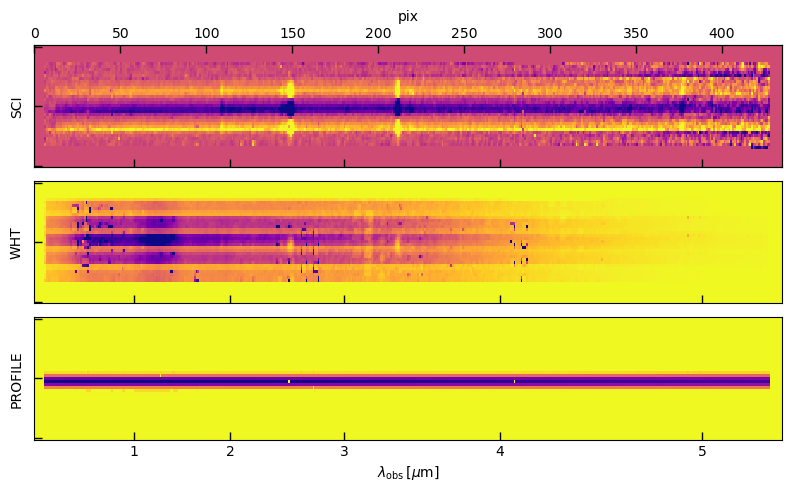

In [10]:
fig, axes = plt.subplots(3,1, figsize=(8, 5), sharex=True, sharey=True)

msk = img['WHT'].data > 0

for i, k in enumerate(['SCI','WHT','PROFILE']):
    _data = img[k].data
    vm = np.percentile(_data[msk], [2,99])
    ax = axes[i]
    ax.imshow(_data, vmin=vm[0], vmax=vm[1], cmap='plasma_r', aspect='auto')
    ax.set_ylabel(k)
    ax.set_yticklabels([])
    
xtv = [1,2,3,4,5]
xti = np.interp(xtv, spec['wave'], np.arange(len(spec)))

a2 = axes[0].twiny()
a2.set_xlabel('pix')
a2.set_xlim(0, _data.shape[1])

ax.set_xticks(xti)
ax.set_xticklabels(xtv)

ax.set_xlabel(r'$\lambda_\mathrm{obs}\,[\mu\mathrm{m}]$')

_ = fig.tight_layout(pad=1)

## Optimal extraction profile

The 1D spectrum is created with an "optimal" ([Horne 1986](https://ui.adsabs.harvard.edu/abs/1986PASP...98..609H/)) extraction where the profile was fit to the observed spectrum both in terms of the center and wavelength-dependent width.

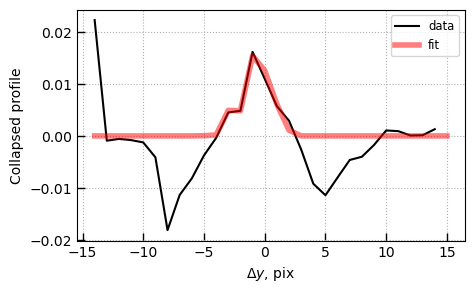

In [11]:
# Collapsed 1D profile
p1 = utils.GTable(img['PROF1D'].data)

fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.plot(p1['pix'], p1['profile'], label='data', color='k')
ax.plot(p1['pix'], p1['pfit'], label='fit', color='r', lw=4, alpha=0.5)

ax.set_xlabel(r'$\Delta y$, pix')
ax.set_ylabel('Collapsed profile')
ax.legend()

ax.grid()


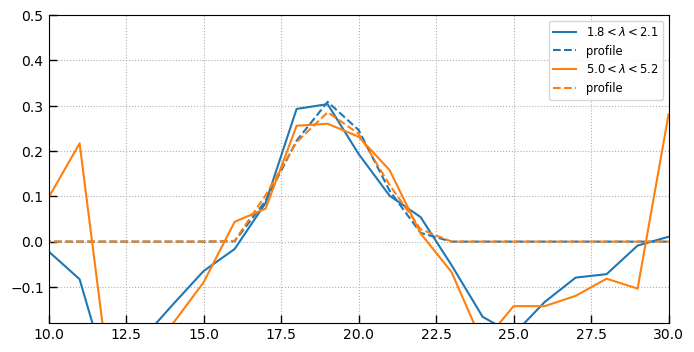

In [12]:
wlims = [(1.8, 2.1), (5, 5.2)]
fig, ax = plt.subplots(1, 1, figsize=(8, 4), sharex=True)

w2d = np.ones(img['SCI'].data.shape)*spec['wave']

for i, wlim in enumerate(wlims):
    msk = (w2d > wlim[0]) & (w2d < wlim[1]) & (img['WHT'].data > 0)
    ydata = (img['SCI'].data*msk).sum(axis=1)
    pdata = (img['PROFILE'].data*msk).sum(axis=1)
    
    anorm = (ydata*pdata).sum()/(pdata**2).sum()
    pdata *= anorm
    norm = pdata.sum()
    
    pl = ax.plot(ydata/norm, label=r'$xx < \lambda < yy$'.replace('xx', f'{wlim[0]:.1f}').replace('yy', f'{wlim[1]:.1f}'))
    ax.plot(pdata/norm, label='profile', color=pl[0].get_color(), linestyle='--')
    
ax.set_ylim(-0.18, 0.5)
ax.legend()
ax.set_xlim(10,30)
ax.grid()


## 1D spectra

Some tools in [msaexp.spectrum.SpectrumSampler](https://github.com/gbrammer/msaexp/blob/main/msaexp/spectrum.py#L122) for interacting with 1D spectra. 

In [13]:
# Open the files into 1D objects, directly from the web
sobj = {}
for u in urls:
    print(f'Read {u}')
    key = os.path.basename(u)
    sobj[key] = msaexp.spectrum.SpectrumSampler(u)

Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-deep-hr-v1/gds-deep-hr-v1_g395h-f290lp_1210_15157.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-deep-lr-v1/gds-deep-lr-v1_prism-clear_1210_15157.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-deep-mr-v1/gds-deep-mr-v1_g140m-f070lp_1210_15157.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-deep-mr-v1/gds-deep-mr-v1_g235m-f170lp_1210_15157.spec.fits
Read https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-deep-mr-v1/gds-deep-mr-v1_g395m-f290lp_1210_15157.spec.fits


In [14]:
# A single (prism) spectrum

for i, k in enumerate(sobj):
    if 'prism' in k:
        break

sp = sobj[k]
sp.spec.info()

<GTable length=435>
  name    dtype  unit
-------- ------- ----
    wave float64     
    flux float64     
     err float64     
    corr float64     
  escale float64     
full_err float64  uJy
   valid    bool     
       R float64     
 to_flam float64     


In [15]:
# Metadata about the 1D extraction
for i, k in enumerate(sp.spec.meta):
    print(f"{k} : {sp.spec.meta[k]}")
    if k == 'CRDS2':
        break
        
print('...')

VERSION : 0.6.12.dev18+gc61a335
TOMUJY : 1.0
PROFCEN : -0.9085424632954114
PROFSIG : 1.263439656446174
PROFSTRT : 0
PROFSTOP : 435
YTRACE : 20.0
EXTNAME : SPEC1D
CRPIX1 : 218
CRPIX2 : 21
CRPIX3 : 1
CRVAL1 : 34478.17210692866
CRVAL2 : 53.11342711704571
CRVAL3 : -27.80296418104931
CD1_1 : 112.0143042734245
CD2_2 : -2.5018683716805e-05
CD3_2 : 4.3106889543069e-06
CD2_3 : 1.0
CD3_3 : 1.0
CTYPE1 : WAVELEN
CTYPE2 : RA---TAN
CTYPE3 : DEC--TAN
CUNIT1 : Angstrom
CUNIT2 : deg
CUNIT3 : deg
RADESYS : ICRS
WCSNAME : SLITWCS
SLIT_PA : 99.77600798539926
PSCALE : 0.09145217434882043
SLIT_Y0 : 0.1046029202771379
SLIT_DY : -0.2
LMIN : 5.336618171269953
DLAM : 0.01120143042734245
BKGOFF : 6
OTHRESH : 30
WSAMPLE : 1.05
LOGWAVE : False
BUNIT : mJy
GRATING : PRISM
FILTER : CLEAR
NFILES : 36
EFFEXPTM : 99788.00399999997
SRCNAME : 1210_15157
SRCID : 15157
SRCRA : 53.113326
SRCDEC : -27.80299179999997
FILE1 : jw01210001001_11101_00001_nrs1_phot.247.1210_15157.fits
CALVER1 : 1.9.4
CRDS1 : jwst_1084.pmap
GRAT1 :

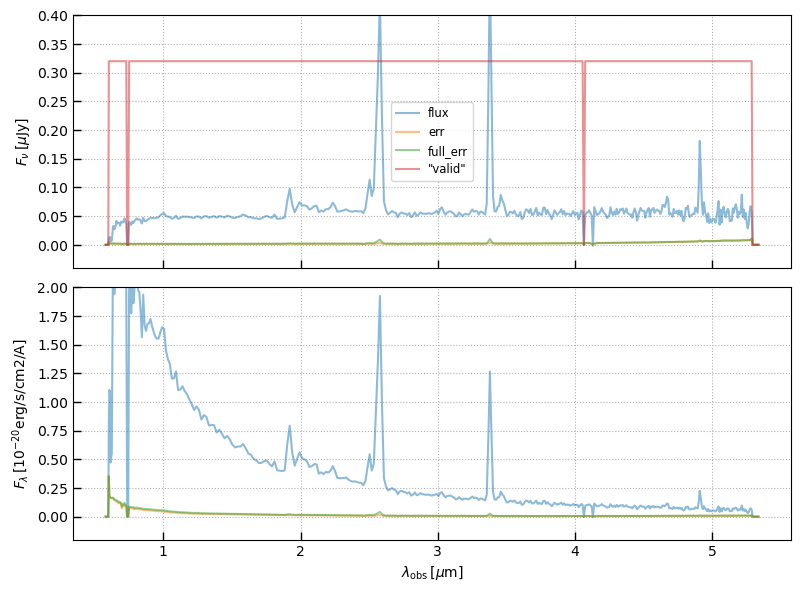

In [16]:
fig, axes = plt.subplots(2,1,figsize=(8,6), sharex=True)
ax = axes[0]

for c in ['flux','err','full_err']:
    ax.plot(sp.spec_wobs, sp.spec[c], alpha=0.5, label=c)
#ax.plot(sp.spec_wobs, sp.spec['err'], alpha=0.5, label='err')
#ax.plot(sp.spec_wobs, sp.spec['full_err'], alpha=0.5, label='full_err')

ax.set_ylim(-0.1*ymax[1], ymax[1])
ax.plot(sp.spec_wobs, sp.valid*ymax[1]*0.8, alpha=0.5, label='"valid"')
ax.grid()
ax.legend()
ax.set_ylabel(r'$F_\nu\,[\mu\mathrm{Jy}]$')

ax = axes[1]
for c in ['flux','err','full_err']:
    ax.plot(sp.spec_wobs, sp.spec[c]*sp.spec['to_flam'], alpha=0.5, label=c)

ax.set_ylim(-0.1*ymax[1]*5, ymax[1]*5)
ax.set_ylabel(r'$F_\lambda\,[10^{-20}\mathrm{erg/s/cm2/A}]$')
ax.grid()

ax.set_xlabel(r'$\lambda_\mathrm{obs}\,[\mu\mathrm{m}]$')

_ = fig.tight_layout(pad=1)

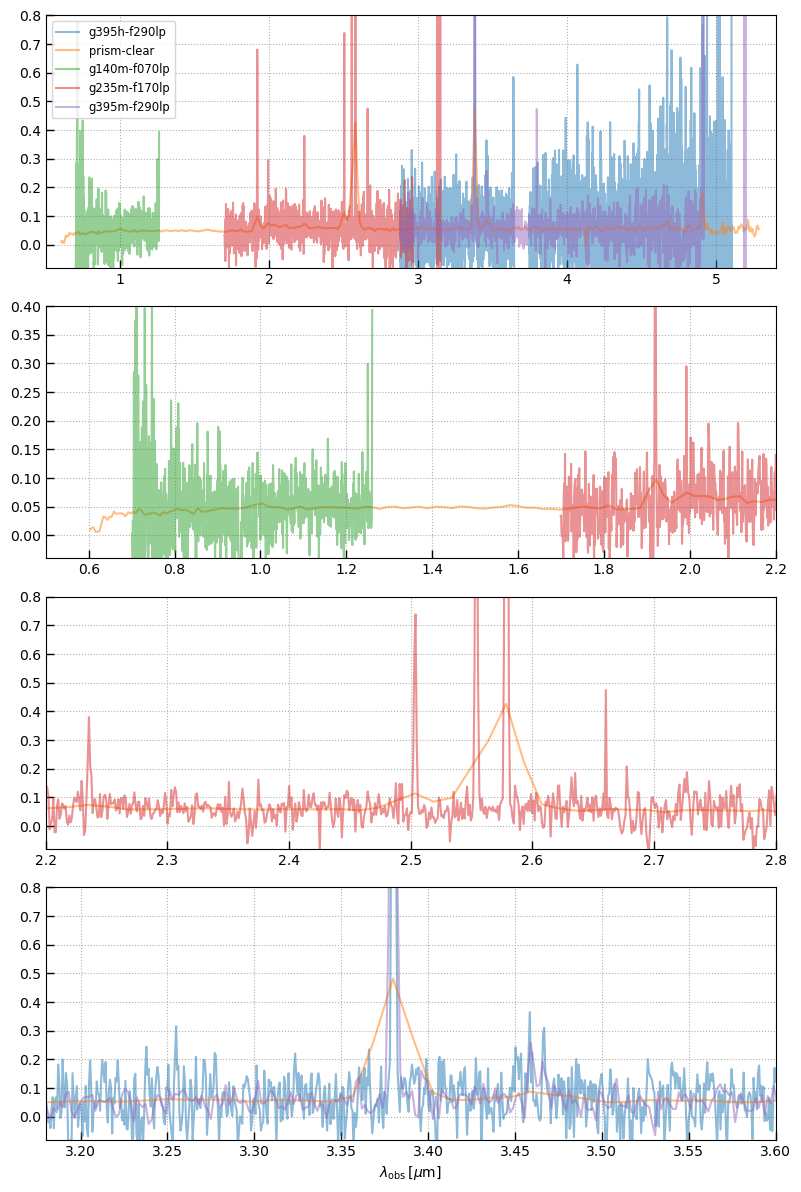

In [17]:
# Show all spectra
fig, axes = plt.subplots(len(xlimits),1,figsize=(8,3*len(xlimits)))

for ax, xlim, ym in zip(axes, xlimits, ymax):
    for i, k in enumerate(sobj):
        sp = sobj[k]
        ax.plot(sp.spec_wobs[sp.valid], sp.spec['flux'][sp.valid], alpha=0.5, label=k.split('_')[1])
    
    ax.set_xlim(*xlim)

    ax.set_ylim(-0.1*ym, ym)
    ax.grid()
    
axes[0].legend()
ax.set_xlabel(r'$\lambda_\mathrm{obs}\,[\mu\mathrm{m}]$')

_ = fig.tight_layout(pad=1)

## Spectral resolution

In [18]:
sp.spec.info()

<GTable length=1414>
  name    dtype  unit
-------- ------- ----
    wave float64     
    flux float64     
     err float64     
    corr float64     
  escale float64     
full_err float64  uJy
   valid    bool     
       R float64     
 to_flam float64     


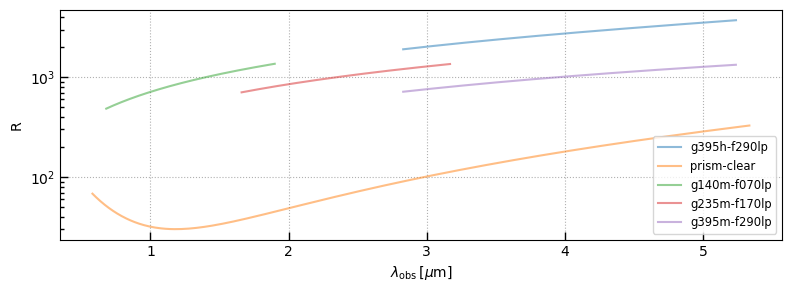

In [19]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

for i, k in enumerate(sobj):
    sp = sobj[k]
    ax.plot(sp.spec_wobs, sp.spec['R'], alpha=0.5, label=k.split('_')[1])

ax.legend()
ax.set_ylabel('R')
ax.grid()
ax.semilogy()

ax.set_xlabel(r'$\lambda_\mathrm{obs}\,[\mu\mathrm{m}]$')

_ = fig.tight_layout(pad=1)      

In [20]:
lw, lr = utils.get_line_wavelengths()

bspl = sp.bspline_array(nspline=21)
bspl.shape

lines = ['Ha','SII-6717','SII-6731']
line_waves = []
for l in lines:
    line_waves += lw[l]


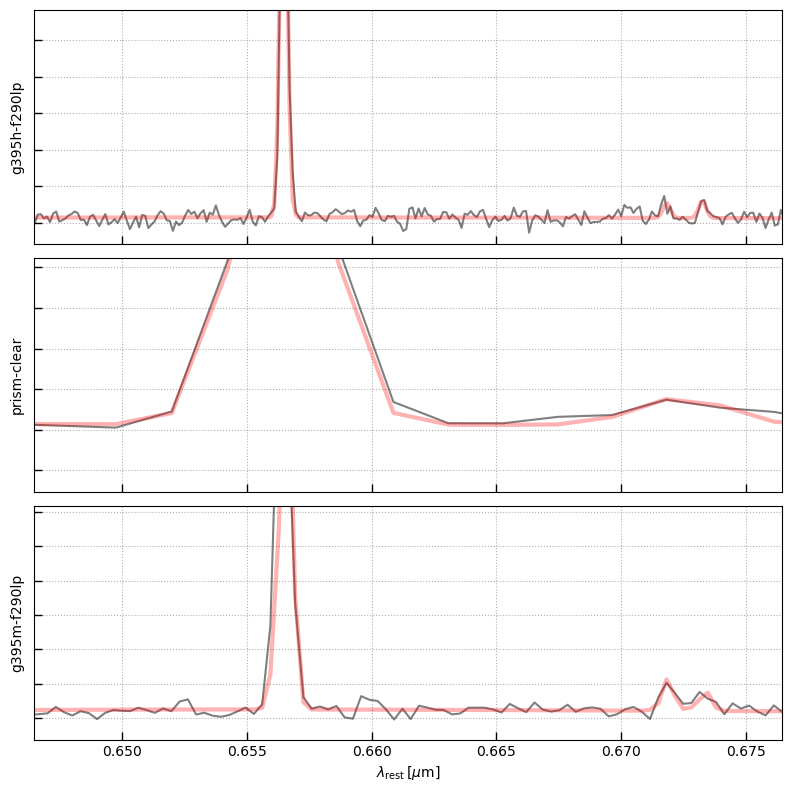

In [21]:

line_um = lw['Ha'][0]*(1+z)/1.e4

fig, axes = plt.subplots(3,1,figsize=(8,8), sharex=True, sharey=False)

counter = 0

for i, k in enumerate(sobj):
    sp = sobj[k]
    if sp.spec_wobs.max() < 3.3:
        continue
    
    ax = axes[counter]
    ax.plot(sp.spec_wobs[sp.valid]/(1+z), sp.spec['flux'][sp.valid], alpha=0.5, label=k.split('_')[1], color='k')
    
    ax.set_yticklabels([])
    ax.set_ylabel(k.split('_')[1])
        
    ### Full line fit
    
    # Dummy spline continuum
    bspl = sp.bspline_array(nspline=21)

    # Generate emission line templates accounting for spectral resolution
    line_in_grating = []
    for lwi in line_waves:
        line_in_grating.append(sp.emission_line(lwi*(1+z)/1.e4,
                                                line_flux=1,
                                                scale_disp=1.3, velocity_sigma=50))

    A = np.vstack([bspl, line_in_grating])
    Ax = A/sp.spec['full_err']
    yx = sp.spec['flux']/sp.spec['full_err']

    lsq = np.linalg.lstsq(Ax[:,sp.valid].T, yx[sp.valid])

    model = A.T.dot(lsq[0])
    ax.plot(sp.spec_wobs/(1+z), model, color='r', lw=3, alpha=0.3)
    
    lwi = np.abs(sp.spec_wobs - line_um) < 0.1
    ym = model[lwi].max()*0.5
    ax.set_ylim(-0.1*ym, ym)

    ax.grid()
    counter += 1
    
ax.set_xlim(line_um/(1+z)-0.01, line_um/(1+z)+0.02)

ax.set_xlabel(r'$\lambda_\mathrm{rest}\,[\mu\mathrm{m}]$')

_ = fig.tight_layout(pad=1)      

## Smooth a full template

Generate a template here, but can also be, e.g. a FSPS or bagpipes model


In [22]:
import eazy.templates

wtempl = np.logspace(3, 4, 4096*4)
ftempl = wtempl*0.

for w in line_waves:
    dv = (wtempl-w)/w*3.e5
    vwidth = 50
    ftempl += 1/np.sqrt(2*np.pi*vwidth**2) * np.exp(-dv**2/2/vwidth**2)

templ = eazy.templates.Template(arrays=(wtempl, ftempl*1.e11))

(3.3599737502612492, 3.4999737502612494)

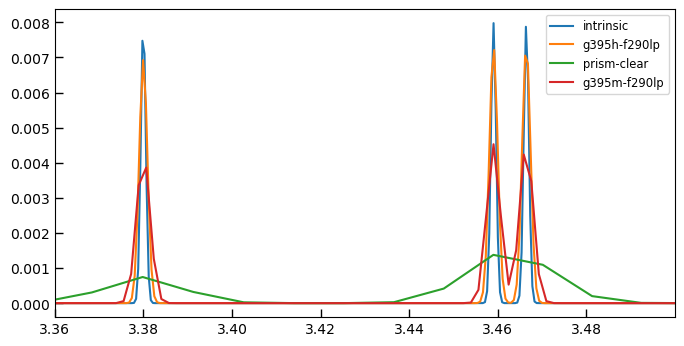

In [23]:
# Now fold it through the spectrum dispersion

fig, ax = plt.subplots(1,1,figsize=(8,4), sharex=True, sharey=False)

counter = 0

ax.plot(wtempl*(1+z)/1.e4, ftempl, label='intrinsic')

for i, k in enumerate(sobj):
    sp = sobj[k]
    if sp.spec_wobs.max() < 3.3:
        continue

    resamp = sp.resample_eazy_template(templ, z=z, scale_disp=1.3, velocity_sigma=50)
    ax.plot(sp.spec_wobs, resamp, label=k.split('_')[1])
    
ax.legend()
ax.set_xlim(line_um-0.02, line_um+0.12)


In [24]:
# Profile the resample function
%timeit resamp = sp.resample_eazy_template(templ, z=z, scale_disp=1.3, velocity_sigma=50)

898 µs ± 4.18 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Full fitting functions

These are the `msaexp` functions that were used to fit the reshifts and line fluxes in the full catalog.

In [35]:
for url in urls:
    if 'prism' in url:
        break

_file = os.path.basename(url)
if not os.path.exists(_file):
    ! wget {url}


# line flux err
# flux x 10^-20 erg/s/cm2
# https://s3.amazonaws.com/msaexp-nirspec/extractions/gds-deep-lr-v1/gds-deep-lr-v1_prism-clear_1210_15157.spec.fits
# z = 4.14871
# Tue Jul 18 20:51:15 2023
             line Hb       76.2 ±      3.7
             line Hg       26.2 ±      6.1
             line Hd       18.2 ±      4.9
         line Ha+NII      263.0 ±      4.2
     line NeIII-3968       26.3 ±      5.7
      line OIII-4959      185.4 ±      5.8
      line OIII-5007      452.2 ±      8.6
      line OIII-4363        1.2 ±      5.8
            line OII      131.9 ±      7.2
      line HeII-4687       -1.5 ±      3.1
     line NeIII-3867       40.2 ±     10.1
       line HeI-3889       12.5 ±      9.5
            line SII       19.7 ±      1.4
       line OII-7325        5.2 ±      1.1
     line ArIII-7138        3.3 ±      1.0
     line ArIII-7753        1.4 ±      0.9
      line SIII-9068        6.9 ±      1.0
      line SIII-9531       20.0 ±      1.5
        line OI-6302     

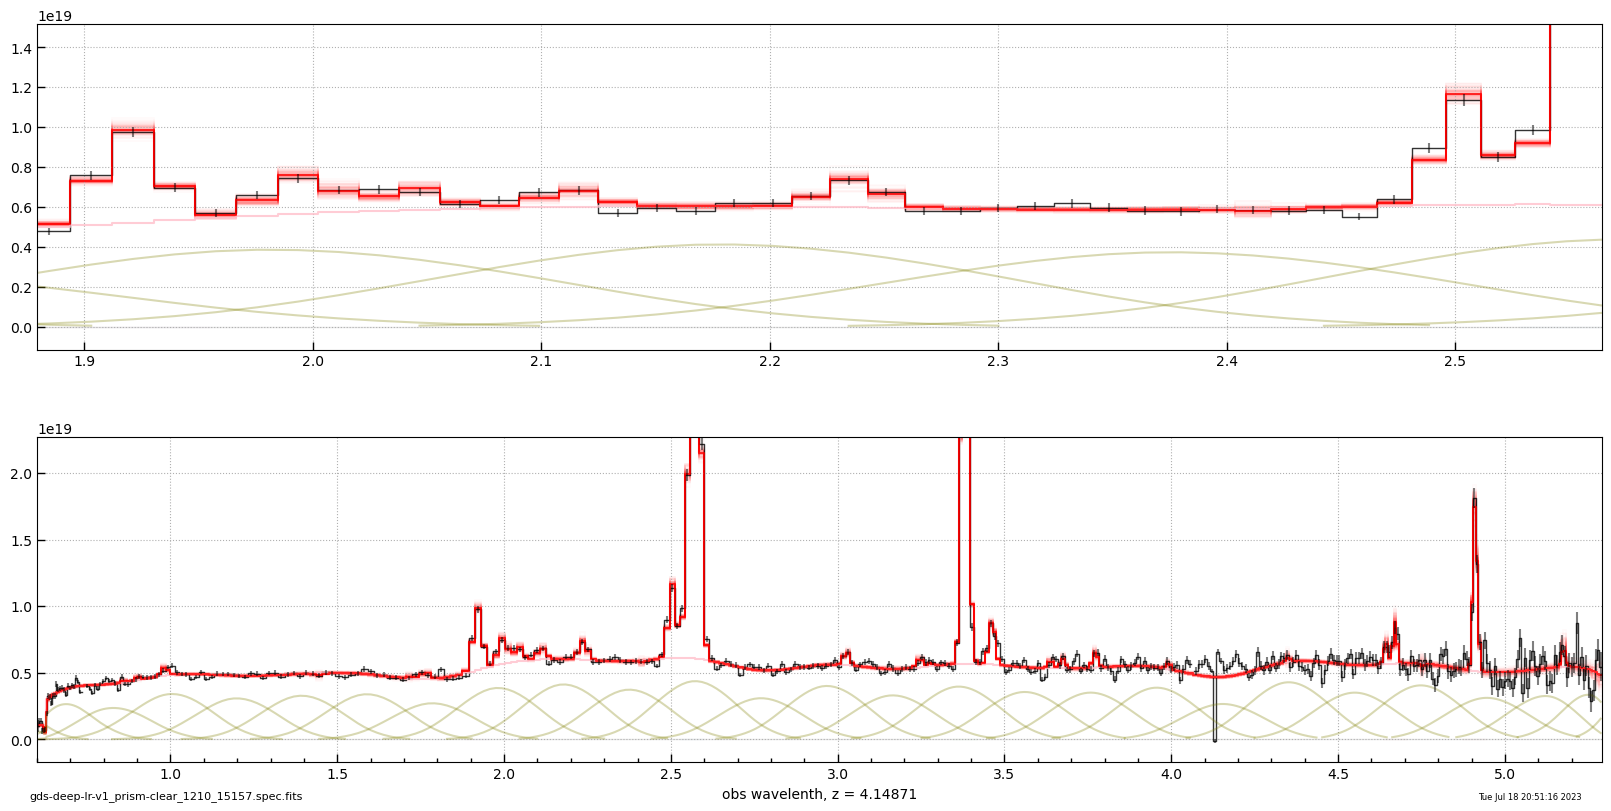

In [40]:
import astropy.units
_ = msaexp.spectrum.plot_spectrum(url, z=z, plot_unit=astropy.units.microJansky)

20it [00:00, 99.05it/s] 
101it [00:01, 87.09it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# gds-deep-lr-v1_prism-clear_1210_15157.spec.fits
# z = 4.14755
# Tue Jul 18 20:50:21 2023
             line Hb       76.9 ±      3.9
             line Hg       27.2 ±      6.3
             line Hd       17.0 ±      5.8
         line Ha+NII      265.8 ±      4.2
     line NeIII-3968       22.9 ±      6.3
      line OIII-4959      174.2 ±      5.9
      line OIII-5007      457.3 ±      8.8
      line OIII-4363        2.2 ±      5.9
            line OII      132.0 ±      7.7
      line HeII-4687       -0.1 ±      3.2
     line NeIII-3867       37.7 ±     10.5
       line HeI-3889       11.9 ±      9.7
            line SII       17.4 ±      1.5
       line OII-7325        4.9 ±      1.1
     line ArIII-7138        2.7 ±      1.1
     line ArIII-7753        0.7 ±      1.0
      line SIII-9068        7.0 ±      1.0
      line SIII-9531       16.5 ±      1.5
        line OI-6302        7.6 ±      1.9
            line PaD        1.6 ±      1.2
      

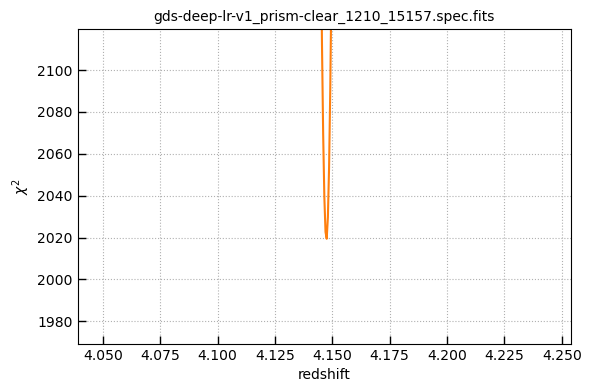

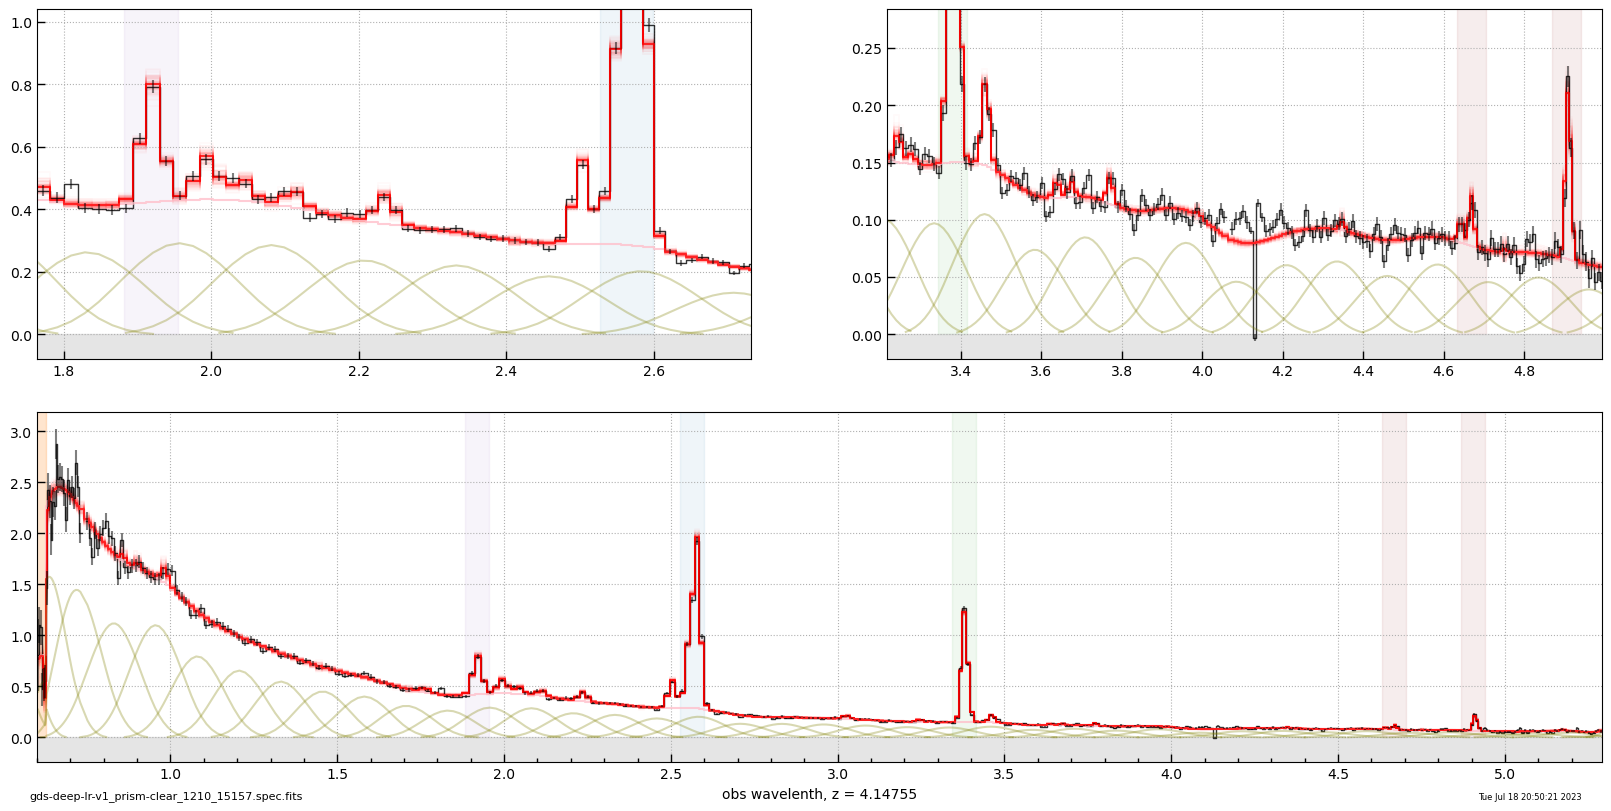

In [37]:
# Fit redshift
_ = msaexp.spectrum.fit_redshift(_file, z0=[z-0.1, z+0.1])

# TBD

Items under development: 

- Scale spectrum to photometry
- Fit for emission line widths